# Part I: Federated Learning in a Nutshell

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phdcybersec/nof_2023/blob/main/notebooks/part1.ipynb)

In this first part, we will go over the basic concepts of experimenting with federated learning (FL), using the Flower framework, and TensorFlow as the machine learning (ML) backend. We will see how we can leverage Flower's simulation capabilities to run a horizontal FL experiment in cross-device setting, using the MNIST dataset and a simple convolutional model.

## Section 0: Prerequisites

### Dependencies

First, let's make sure that the correct dependencies are installed. If you are running this notebook locally, please see the README for instructions on how to install the appropriate dependencies. If you are running this notebook on Google Colab, you can run the following cell:

In [1]:
import os
from IPython.core.getipython import get_ipython

if "google.colab" in str(get_ipython()):
    !git clone https://github.com/phdcybersec/nof_2023.git
    %pip install poetry
    %pip install -r <(poetry export -C nof_2023/)
    !rm -r nof_2023/

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from flwr.common import Metrics
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
import flwr
from tensorflow import keras
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
from numpy.typing import NDArray
from typing import cast
from typing import Callable

...and check that everything is working as expected. If you have access to a GPU, either on Colab on on your local machine, it should be detected and used by TensorFlow. We also use a Flower utility function to allow TensorFlow to share the GPU memory between multiple processes, which is necessary for running multiple clients in parallel.

In [3]:
print("TensorFlow version:", tf.__version__)
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
enable_tf_gpu_growth()

TensorFlow version: 2.10.1
Num GPUs Available: 2


To allow others to reproduce your results with certitude, set a seed for all the pseudo-random number generators (PRNG) that you use. You should also run your threads deterministically, in case your ML backend optimize training. This will have a negative impact on the performance. On TensorFlow: 

In [4]:
SEED = 1138
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

### Section 1: Data exploration and partitioning

MNIST is a basic datasets often use as an easy benchmark for computer-vision algorithms. It contains 28x38 grayscale pictures of handwritten digits (from 0 to 9). One typical task is to classify each digit to its corresponding class.

The dataset is bundled in a lot of ML frameworks, including TensorFlow. Let's laod it and explore it.

In [5]:
def load_mnist():
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # Make sure images have shape (28, 28, 1)
    print("x_train shape:", x_train.shape)
    print(x_train.shape[0], "train samples")
    print(x_test.shape[0], "test samples")

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)

    return (x_train, y_train), (x_test, y_test)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


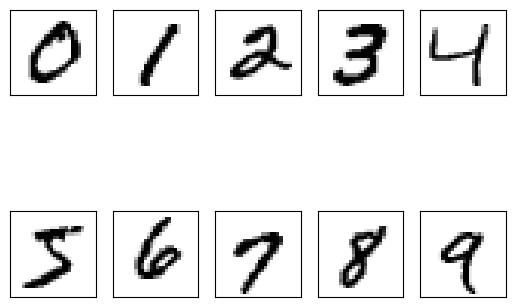

In [6]:
(x_train, y_train), (x_test, y_test) = load_mnist()

fig, ax = plt.subplots(2, 5)
for i, ax in enumerate(ax.flatten()):
    im_idx = np.argwhere(y_train[:, i] == 1)[0]
    plottable_image = np.reshape(x_train[im_idx], (28, 28))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.imshow(plottable_image, cmap="gray_r")

y_train shape: (60000, 10)
example: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


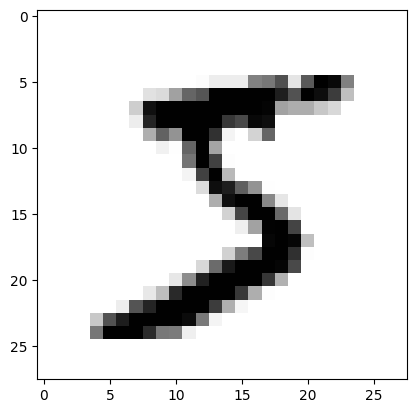

In [7]:
print("y_train shape:", y_train.shape)
print("example:", y_train[0])
# show the first image
plt.imshow(x_train[0].reshape(28, 28), cmap="gray_r")

To train a federation of devices one needs to partition the dataset into multiple subsets, one for each device. Partitions are sometimes referred to as shards, one shard of the training set per client.

For research purposes, as we have the entire dataset, we can use one testing set to evaluate the performance of the model. In a real-world scenario, we would not have access to the testing set, and each client would have to evaluate the model on its own data.

In [8]:
def partition(num_shards: int, dataset: tuple[NDArray, NDArray]):
    """Download and partitions the MNIST dataset."""
    X, y = dataset
    partitions = []
    # We keep all partitions equal-sized in this example
    partition_size = math.floor(len(X) / num_shards)
    shuffle_idx = np.random.permutation(len(X))
    # X, y = X[shuffle_idx], y[shuffle_idx]
    for cid in range(num_shards):
        # Split dataset into non-overlapping NUM_CLIENT partitions
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        partitions.append((X[idx_from:idx_to], y[idx_from:idx_to]))
    return partitions

## Section 2: Local training

Training a model means finding the best parameters for it, so that it can correctly classify the
data. This is done by minimizing a loss function, which is a measure of how well the model performs
on the training data. The loss function is computed on the training data, and the model is updated
to minimize it. This process is repeated until the loss function converges to a local minimum.

In [9]:
# Model / data parameters
BATCH_SIZE = 128
NUM_CLIENTS = 100

MNIST is an "easy" problem, with low-dimensional images and a small number of classes. A simple deep-learning model architecture suffise to obtain relevant results.

In [10]:
def mk_model() -> keras.Model:
    """Create a simple DNN model for MNIST classification."""

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )

    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    return model


mk_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


We will use the `fit` method of the Keras model to train it over 10 epochs. We will also use a batch
size of 128, which means that the model will be updated after each batch of 128 samples. This is a
good default value if you have computing resources, but you can experiment with it to see if it improves the results.

Note: a smaller batch size will result in more steps per epoch, and therefore a longer training time. 

In [11]:
EPOCHS = 10

(x_train, y_train), (x_test, y_test) = load_mnist()
shards = partition(NUM_CLIENTS, (x_train, y_train))

# test the performance of the model on client 1
x_train, y_train = shards[0]

model = mk_model()
hist = model.fit(
    x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1
)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
Epoch 1/10
5/5 [==============================] - 2s 57ms/step - loss: 2.1530 - accuracy: 0.2648 - val_loss: 1.8504 - val_accuracy: 0.5833
Epoch 2/10
5/5 [==============================] - 0s 15ms/step - loss: 1.6502 - accuracy: 0.6278 - val_loss: 1.5177 - val_accuracy: 0.6833
Epoch 3/10
5/5 [==============================] - 0s 15ms/step - loss: 1.2816 - accuracy: 0.7333 - val_loss: 1.2286 - val_accuracy: 0.7833
Epoch 4/10
5/5 [==============================] - 0s 15ms/step - loss: 0.9884 - accuracy: 0.7796 - val_loss: 1.0196 - val_accuracy: 0.8500
Epoch 5/10
5/5 [==============================] - 0s 14ms/step - loss: 0.7811 - accuracy: 0.8222 - val_loss: 0.8545 - val_accuracy: 0.8333
Epoch 6/10
5/5 [==============================] - 0s 14ms/step - loss: 0.6570 - accuracy: 0.8500 - val_loss: 0.7415 - val_accuracy: 0.8500
Epoch 7/10
5/5 [==============================] - 0s 14ms/step - loss: 0.5370 - accuracy: 0.8815

In [12]:
score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.6072 - accuracy: 0.8176
Test loss: 0.6071969270706177
Test accuracy: 0.8176000118255615


## Part 3: Federated learning

We use Flower to 
In federated learning, the model is trained on multiple clients, which are usually distributed
across the network. Each client has a local dataset, and the model is trained on it. The model is
then sent to the server, which aggregates the updates and sends them back to the clients. The
clients then apply the updates to their local model, and the process is repeated. We call this cycle
a round.

The `flwr` library is a Python implementation of FL. It provides a set of tools to implement a
federated learning in simulations, as well as in real-world applications. It is designed to be easy
to use, and to be compatible with a wide range of ML frameworks, including Tensorflow/Keras.

Its main components are:
- `flwr.client`: contains the `Client` class, which represents a client in the FL process. It
  provides a set of methods that are called by the server during the training process. The client
  can be simulated using `ray`, or run on a real device.
- `flwr.server`: contains the `Server` class, which represents the server in the FL process. It
  acts as a coordinator, and is responsible for managing the training process. 
- `flwr.strategy`: contains the implementation of the aggregation algorithm. `FedAvg` is the most
  common algorithm, and is the one we will use in this tutorial, but `flwr` also provides other
  strategies, such as `FedProx`, `FedOpt`, `FedYogi`, `FedAdagrad`, and `FedAdam`.

Below is a diagram of `flwr`'s architecture, you can find more information in the [documentation](https://flower.dev/docs/architecture.html).

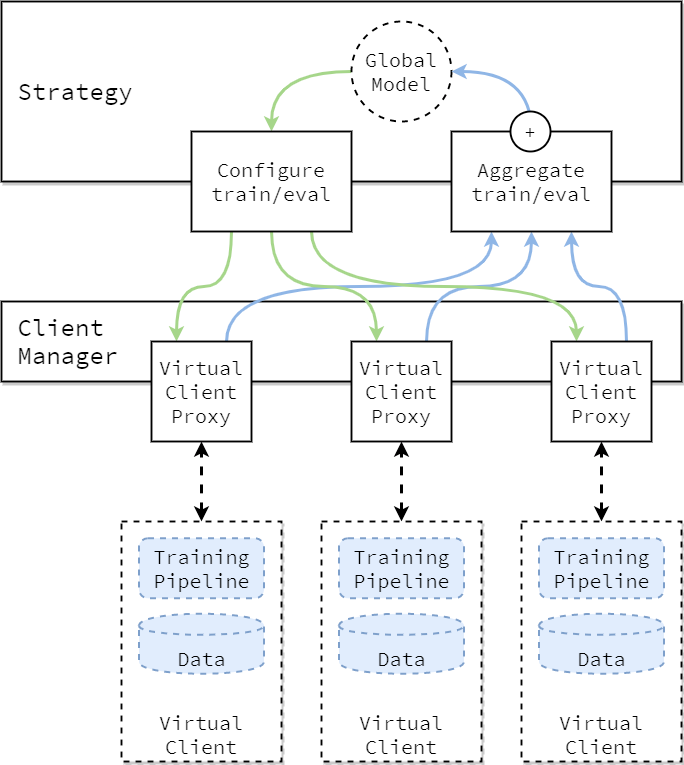


In [13]:
def get_evaluate_fn(testset):
    """Return an evaluation function for server-side (i.e. centralized) evaluation."""
    x_test, y_test = testset

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: flwr.common.NDArrays,
        config: dict[str, flwr.common.Scalar],
    ):
        model = mk_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(x_test, y_test, verbose=cast(str, 0))
        return loss, {"accuracy": accuracy}

    return evaluate

In [14]:
class FlowerClient(flwr.client.NumPyClient):
    def __init__(self, x_train, y_train):  # , x_eval, y_eval) -> None:
        # Create model
        self.model = mk_model()
        self.x_train, self.y_train = x_train, y_train
        # self.x_eval, self.y_eval = x_eval, y_eval

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(
            self.x_train,
            self.y_train,
            epochs=1,
            batch_size=BATCH_SIZE,
            verbose=cast(str, 0),
            validation_split=0.1,
        )
        return self.model.get_weights(), len(self.x_train), {}

In [15]:
def mk_client_fn(
    partitions: list[tuple[NDArray, NDArray]]
) -> Callable[[str], FlowerClient]:
    """Return a function which creates a new FlowerClient for a given partition."""

    def client_fn(cid: str) -> FlowerClient:
        """Create a new FlowerClient for partition i."""
        x_train, y_train = partitions[int(cid)]
        return FlowerClient(x_train, y_train)

    return client_fn

In [16]:
# Enable GPU growth in your main process
enable_tf_gpu_growth()

# Create dataset partitions (needed if your dataset is not pre-partitioned)
trainset, testset = load_mnist()
partitions = partition(NUM_CLIENTS, trainset)


# Create FedAvg strategy
strategy = flwr.server.strategy.FedAvg(
    fraction_fit=0.1,  # Sample 10% of available clients for training
    fraction_evaluate=0,  # Disable federated evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    # min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS * 0.75
    ),  # Wait until at least 75 clients are available
    # evaluate_metrics_aggregation_fn=avg_metrics,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(testset),  # global evaluation function
)

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# Start simulation
history = flwr.simulation.start_simulation(
    client_fn=mk_client_fn(partitions),
    num_clients=NUM_CLIENTS,
    config=flwr.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },
    ray_init_args={"num_gpus": len(tf.config.list_physical_devices("GPU"))},
)

INFO flwr 2023-10-04 13:56:57,072 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


2023-10-04 13:57:00,044	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-10-04 13:57:02,399 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 192.0, 'GPU': 2.0, 'node:__internal_head__': 1.0, 'memory': 581586615296.0, 'object_store_memory': 200000000000.0, 'node:192.168.1.240': 1.0}
INFO flwr 2023-10-04 13:57:02,400 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2023-10-04 13:57:02,500 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 192 actors
INFO flwr 2023-10-04 13:57:02,502 | server.py:89 | Initializing global parameters
INFO flwr 2023-10-04 13:57:02,502 | server.py:276 | Requesting initial parameters from one random client
INFO flwr 2023-10-04 13:57:12,536 | server.py:280 | Received initial parameters from one random client
INFO flwr 2023-10-04 13:57:12,538 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-10-04 13:57:

history.metrics_centralized = {'accuracy': [(0, 0.09080000221729279), (1, 0.5151000022888184), (2, 0.7342000007629395), (3, 0.791100025177002), (4, 0.8179000020027161), (5, 0.8398000001907349), (6, 0.857699990272522), (7, 0.8650000095367432), (8, 0.8747000098228455), (9, 0.8755000233650208), (10, 0.8863999843597412)]}


Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

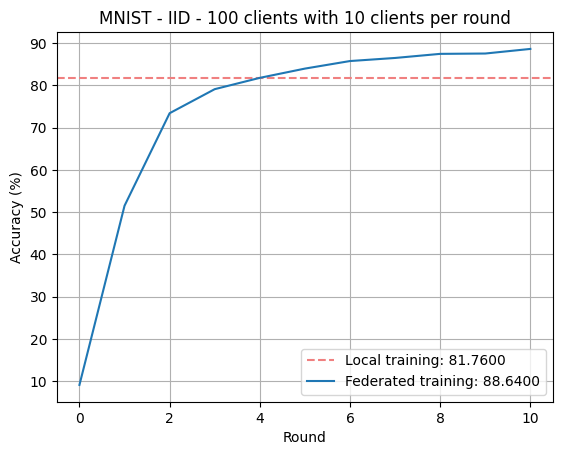

In [17]:
print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]

local = score[1] * 100
plt.axhline(
    y=local, label=f"Local training: {local:.4f}", linestyle="--", color="lightcoral"
)
plt.plot(round, acc, label=f"Federated training: {max(acc):.4f}")
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.legend()
plt.title("MNIST - IID - 100 clients with 10 clients per round")